<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Lecture 6: Spatial clustering</h2>
<h3>IT University of Copenhagen, Spring 2023</h3>
<h3>Instructor: Ane Rahbek Vierø</h3>
</div>


This notebook was adapted from:
* A course on Geographic Data Science: https://darribas.org/gds_course/content/bG/lab_G.html

# Clustering, spatial clustering, and geodemographics

<details>
<summary>Background</summary>

This session covers statistical clustering of spatial observations. Many questions and topics are complex phenomena that involve several dimensions and are hard to summarize into a single variable. In statistical terms, we call this family of problems *multivariate*, as opposed to *univariate* cases where only a single variable is considered in the analysis. Clustering tackles this kind of questions by reducing their dimensionality -the number of relevant variables the analyst needs to look at- and converting it into a more intuitive set of classes that even non-technical audiences can look at and make sense of. For this reason, it is widely use in applied contexts such as policymaking or marketting. In addition, since these methods do not require many preliminary assumptions about the structure of the data, it is a commonly used exploratory tool, as it can quickly give clues about the shape, form and content of a dataset.

The basic idea of statistical clustering is to summarize the information contained in several variables by creating a relatively small number of categories. Each observation in the dataset is then assigned to one, and only one, category depending on its values for the variables originally considered in the classification. If done correctly, the exercise reduces the complexity of a multi-dimensional problem while retaining all the meaningful information contained in the original dataset. This is because, once classified, the analyst only needs to look at in which category every observation falls into, instead of considering the multiple values associated with each of the variables and trying to figure out how to put them together in a coherent sense. When the clustering is performed on observations that represent areas, the technique is often called geodemographic analysis.

Although there exist many techniques to statistically group observations in a dataset, all of them are based on the premise of using a set of attributes to define classes or categories of observations that are similar *within* each of them, but differ *between* groups. How similarity within groups and dissimilarity between them is defined and how the classification algorithm is operationalized is what makes techniques differ and also what makes each of them particularly well suited for specific problems or types of data. As an illustration, we will only dip our toes into one of these methods, K-means, which is probably the most commonly used technique for statistical clustering.

In the case of analysing spatial data, there is a subset of methods that are of particular interest for many common cases in Geographic Data Science. These are the so-called *regionalization* techniques. Regionalization methods can take also many forms and faces but, at their core, they all involve statistical clustering of observations with the additional constraint that observations need to be geographical neighbors to be in the same category. Because of this, rather than category, we will use the term *area* for each observation and *region* for each category, hence regionalization, the construction of regions from smaller areas.

</details>

### New library: sklearn

[scikit-learn](https://scikit-learn.org/stable/index.html) is the core library for machine learning in Python.

In [1]:
%matplotlib inline

import geopandas as gpd
import pandas as pd
import numpy as np

import contextily as cx 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import esda
from splot.libpysal import plot_spatial_weights
from pysal.lib import weights
from sklearn import cluster
from sklearn.preprocessing import robust_scale

sns.set_theme()

## Data

This weeks lecture data is a preprocessed data set with demographic and socio-economic variables for each voting area in Denmark. The original data were downloaded from [Statistics Denmark](https://valgdatabase.dst.dk/).
*Note that there are a few missing data points, which will show up as blank areas on our map.*

For this lecture we will only look at the Greater Copenhagen area and on variables for the **share of households** in different **income brackets**, household **car ownership**, share of **immigrants**, and **population density**.

In [2]:
socio = pd.read_csv('data/socio_economic_data.csv')
areas = gpd.read_file('data/voting_areas.gpkg')

# Just like previous lectures/exercises, we need to join the variables and the geometries
socio_areas = areas.merge(socio,left_on='ValgstedId',right_on='Gruppe',how='inner')

socio_areas.set_index('Gruppe',inplace=True,drop=False)

rename_cols = {
       'households_share_income_under100k':'income_under100k',
       'households_share_income_100-149.9k':'income_100-149.9k',
       'households_share_income_150-199.9k':'income_150-199.9k',
       'households_share_income_200-299.9k':'income_200-299.9k',
       'households_share_income_300-399.9k':'income_300-399.9k',
       'households_share_income_400-499.9k':'income_400-499.9k',
       'households_share_income_500-749.9k':'income_500-749.9k', 
       'households_share_income_750-k':'income_750+k',
       'share_households_1car':'1_car',
       'share_households_2pluscar':'2+cars', 
       'share_households_nocar':'no_car'
}

# Rename columns for nicer plot titles etc. later
socio_areas.rename(rename_cols,axis=1,inplace=True)

socio_areas['low_income'] = socio_areas["income_under100k"] + socio_areas['income_100-149.9k'] + socio_areas["income_150-199.9k"]
socio_areas['medium_income'] = socio_areas["income_200-299.9k"] + socio_areas["income_300-399.9k"] + socio_areas["income_400-499.9k"]
socio_areas['high_income'] = socio_areas["income_500-749.9k"] + socio_areas["income_750+k"]

immi_cols = [
'Nordiske lande',
'Tyrkiet', 
'Tidligere Jugoslavien', 
'Gamle EU-lande', 
'Nye EU-lande',
'Øvrige Europa', 
'Afrika', 
'Nordamerika', 
'Syd- og Mellemamerika',
'Asien og Oceanien', 
'Uoplyst']

socio_areas['immigration'] = socio_areas[immi_cols].sum(axis=1) / socio_areas.total_population

socio_areas['pop_density'] = socio_areas.total_population / (socio_areas.area/1000000)

keep_cols = [
       'Gruppe',
       'municipal_id', 
       'area_name', 
       'geometry', 
       'total_population',
       'pop_density',
       'low_income',
       'medium_income',
       'high_income',
       'immigration',
       'total_households', 
       '1_car',
       '2+cars', 
       'no_car'
]

socio_areas = socio_areas[keep_cols]

muni_codes = [
       '0101',
       '0147',
       '0155',
       '0185',
       '0165',
       '0151',
       '0153',
       '0157',
       '0159',
       '0161',
       '0163',
       '0167',
       '0169',
       '0183',
       '0173',
       '0175',
       '0187',
       '0201',
       '0240',
       '0210',
       '0250',
       '0190',
       '0270',
       '0260',
       '0217',
       '0219',
       '0223',
       '0230'
]

data = socio_areas.loc[socio_areas.municipal_id.isin(muni_codes)].copy()

In [3]:
# Inspect the structure of the table
data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 246 entries, 210008 to 101008
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Gruppe            246 non-null    int64   
 1   municipal_id      246 non-null    object  
 2   area_name         246 non-null    object  
 3   geometry          246 non-null    geometry
 4   total_population  246 non-null    float64 
 5   pop_density       246 non-null    float64 
 6   low_income        246 non-null    float64 
 7   medium_income     246 non-null    float64 
 8   high_income       246 non-null    float64 
 9   immigration       246 non-null    float64 
 10  total_households  246 non-null    float64 
 11  1_car             246 non-null    float64 
 12  2+cars            246 non-null    float64 
 13  no_car            246 non-null    float64 
dtypes: float64(10), geometry(1), int64(1), object(2)
memory usage: 28.8+ KB


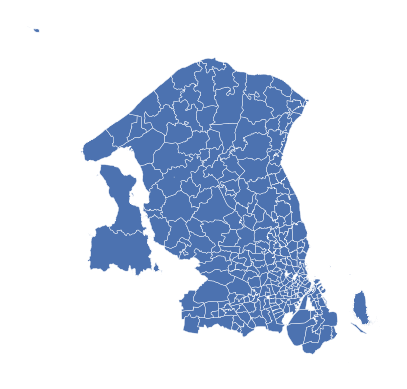

In [4]:
ax = data.plot(linewidth=0.3);
ax.set_axis_off()

Later in this section we will also need the geometries for the municipalities. We can create the municipal geometries by **dissolving** voting areas with the same municipal id:

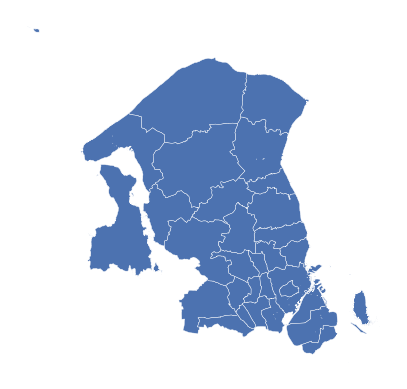

In [5]:
muni = areas[['geometry','municipal_id']].dissolve('municipal_id')

muni = muni.loc[muni_codes]

ax = muni.plot(linewidth=0.3);
ax.set_axis_off()

Before we jump into exploring the data, one additional step that will come in handy down the line. Not every variable in the table is an attribute that we will want for the clustering. 

We are interested in income, population density, share of immigrants, and car ownership column, so we will only consider those. Let us create a list with the names of all columns that we will use for the clustering, so they are easier to subset:


In [6]:
cluster_cols = [ 
'pop_density',
'immigration',
'low_income', 
'medium_income', 
'high_income', 
'1_car', 
'2+cars', 
'no_car'
]

## Getting to know the data


The best way to start exploring the geography of income etc. is by plotting each of them onto a different map. This will give us a **univariate** perspective on each of the variables we are interested in.

Since we have many columns to plot, we will create a loop that generates each map for us and places it on a "subplot" of the main figure:

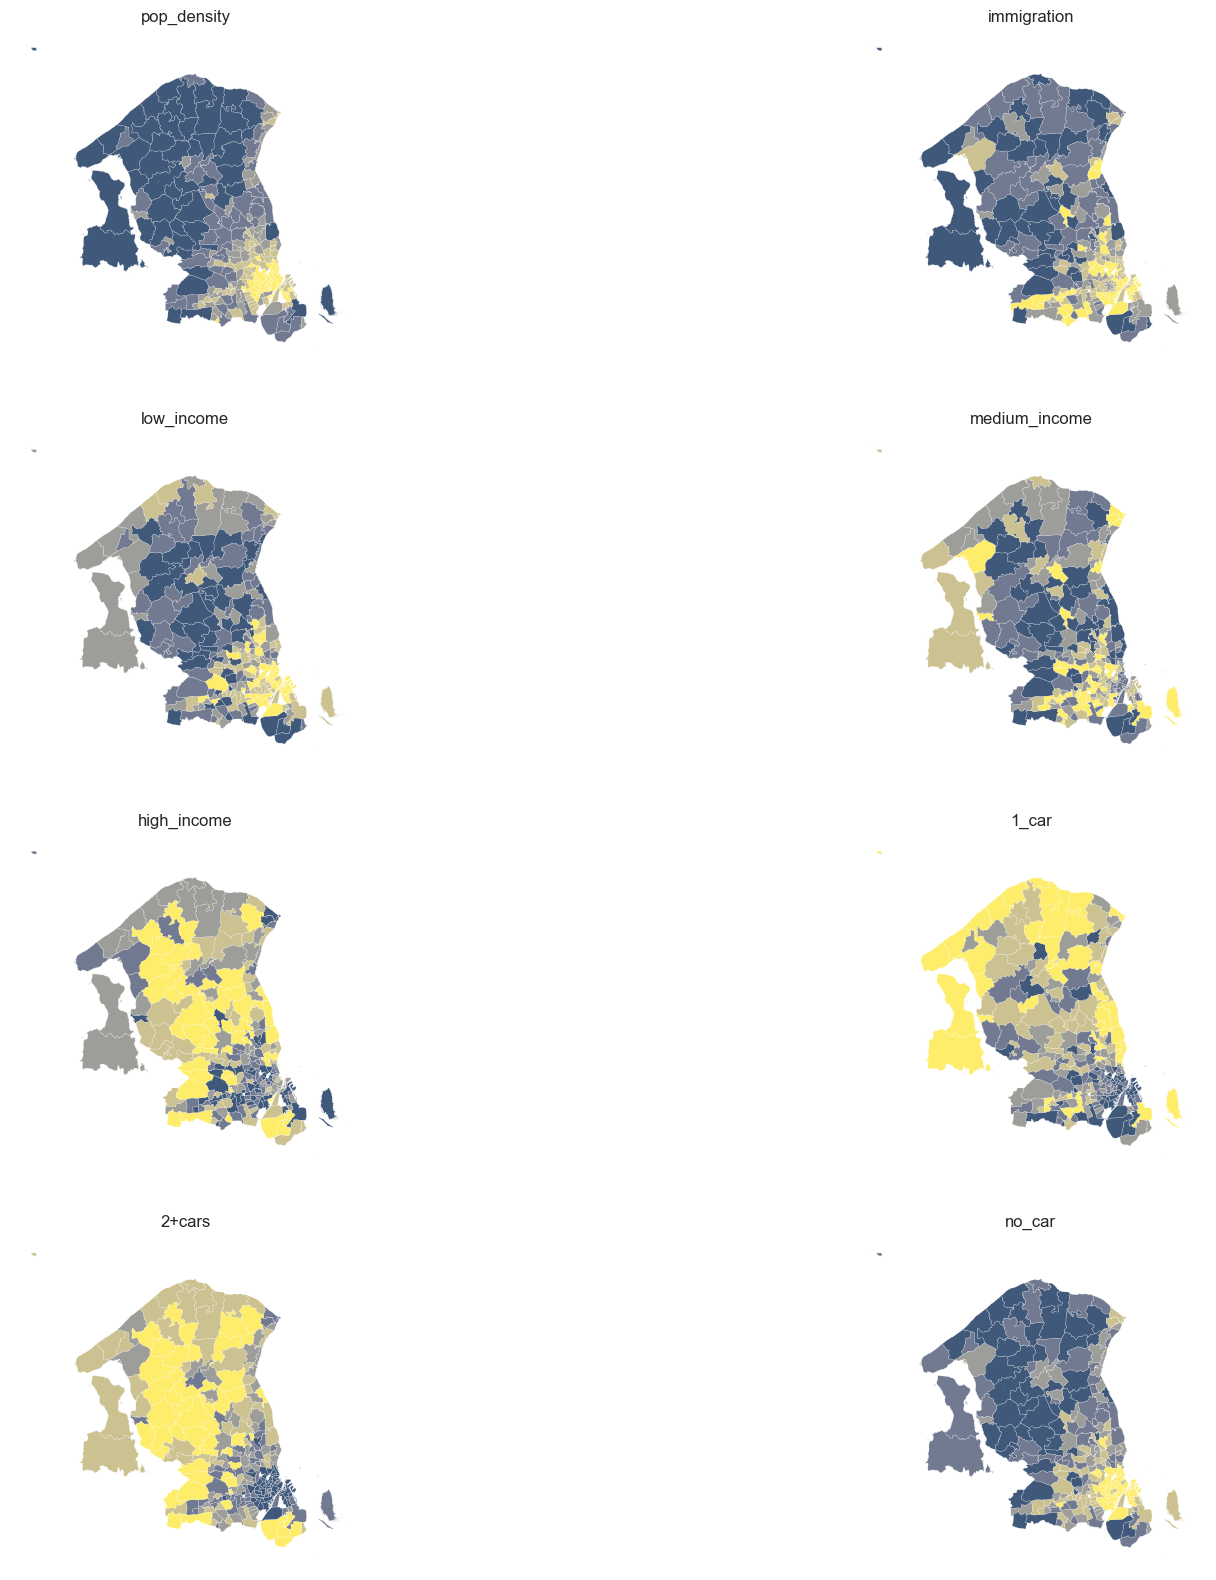

In [7]:
# Create figure and axes (this time it's 9, arranged 3 by 3)
f, axs = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Start the loop over all the variables of interest
for i, col in enumerate(cluster_cols):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    data.plot(
        column=col, 
        ax=ax, 
        scheme='Quantiles',
        linewidth=0.2, 
        cmap='cividis', 
        alpha=0.75,
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)

# Display the figure
plt.show()

<details>

<summary><b>Walk through of plotting method</b></summary>

Let us walk through the process of creating the figure above, which involves several subplots inside the same figure:

* First we set the number of rows and columns we want for the grid of subplots.
* The resulting object, `axs`, is not a single one but a grid (or array) of axis. Because of this, we can't plot directly on `axs`, but instead we need access each individual axis.
* To make that step easier, we *unpack* the grid into a flat list (array) for the axes of each subplot with `flatten` 
* At this point, we set up a `for` loop to plot a map in each of the subplots.
* Within the loop, we extract the axis, plot the choropleth on it and style the map.
* Display the figure.


</details>

As we can see, there is substantial variation in how the variable values are distributed over space. There seems to be a clear urban-rural divide in the pattern for car ownership, but also the household income appear to follow some spatial pattern.

Let's check statistically what we suspect when looking at the plots by eye - that there is a high level of significant clustering for all variables:

In [8]:
w = weights.KNN.from_dataframe(data,k=8)
# Calculate Moran's I for each variable
mi_results = [esda.Moran(data[variable], w) for variable in cluster_cols]
# Structure results as a list of tuples
mi_results = [(variable, res.I, res.p_sim) for variable,res in zip(cluster_cols, mi_results)]
# Display on table
table = pd.DataFrame(
    mi_results,
    columns=['Variable', "Moran's I", 'P-value']
).set_index('Variable')
table

Moran's I  P-value
Variable                         
pop_density     0.713776    0.001
immigration     0.314927    0.001
low_income      0.406747    0.001
medium_income   0.217308    0.001
high_income     0.291909    0.001
1_car           0.448538    0.001
2+cars          0.639598    0.001
no_car          0.722094    0.001

### A multivariate look

Even though we only have eleven variables, it is very hard to "mentally overlay" all of them to come up with an overall assessment of the nature of each part of the area. For pairwise bivariate correlations, a useful tool is the correlation matrix plot, available in `seaborn`:

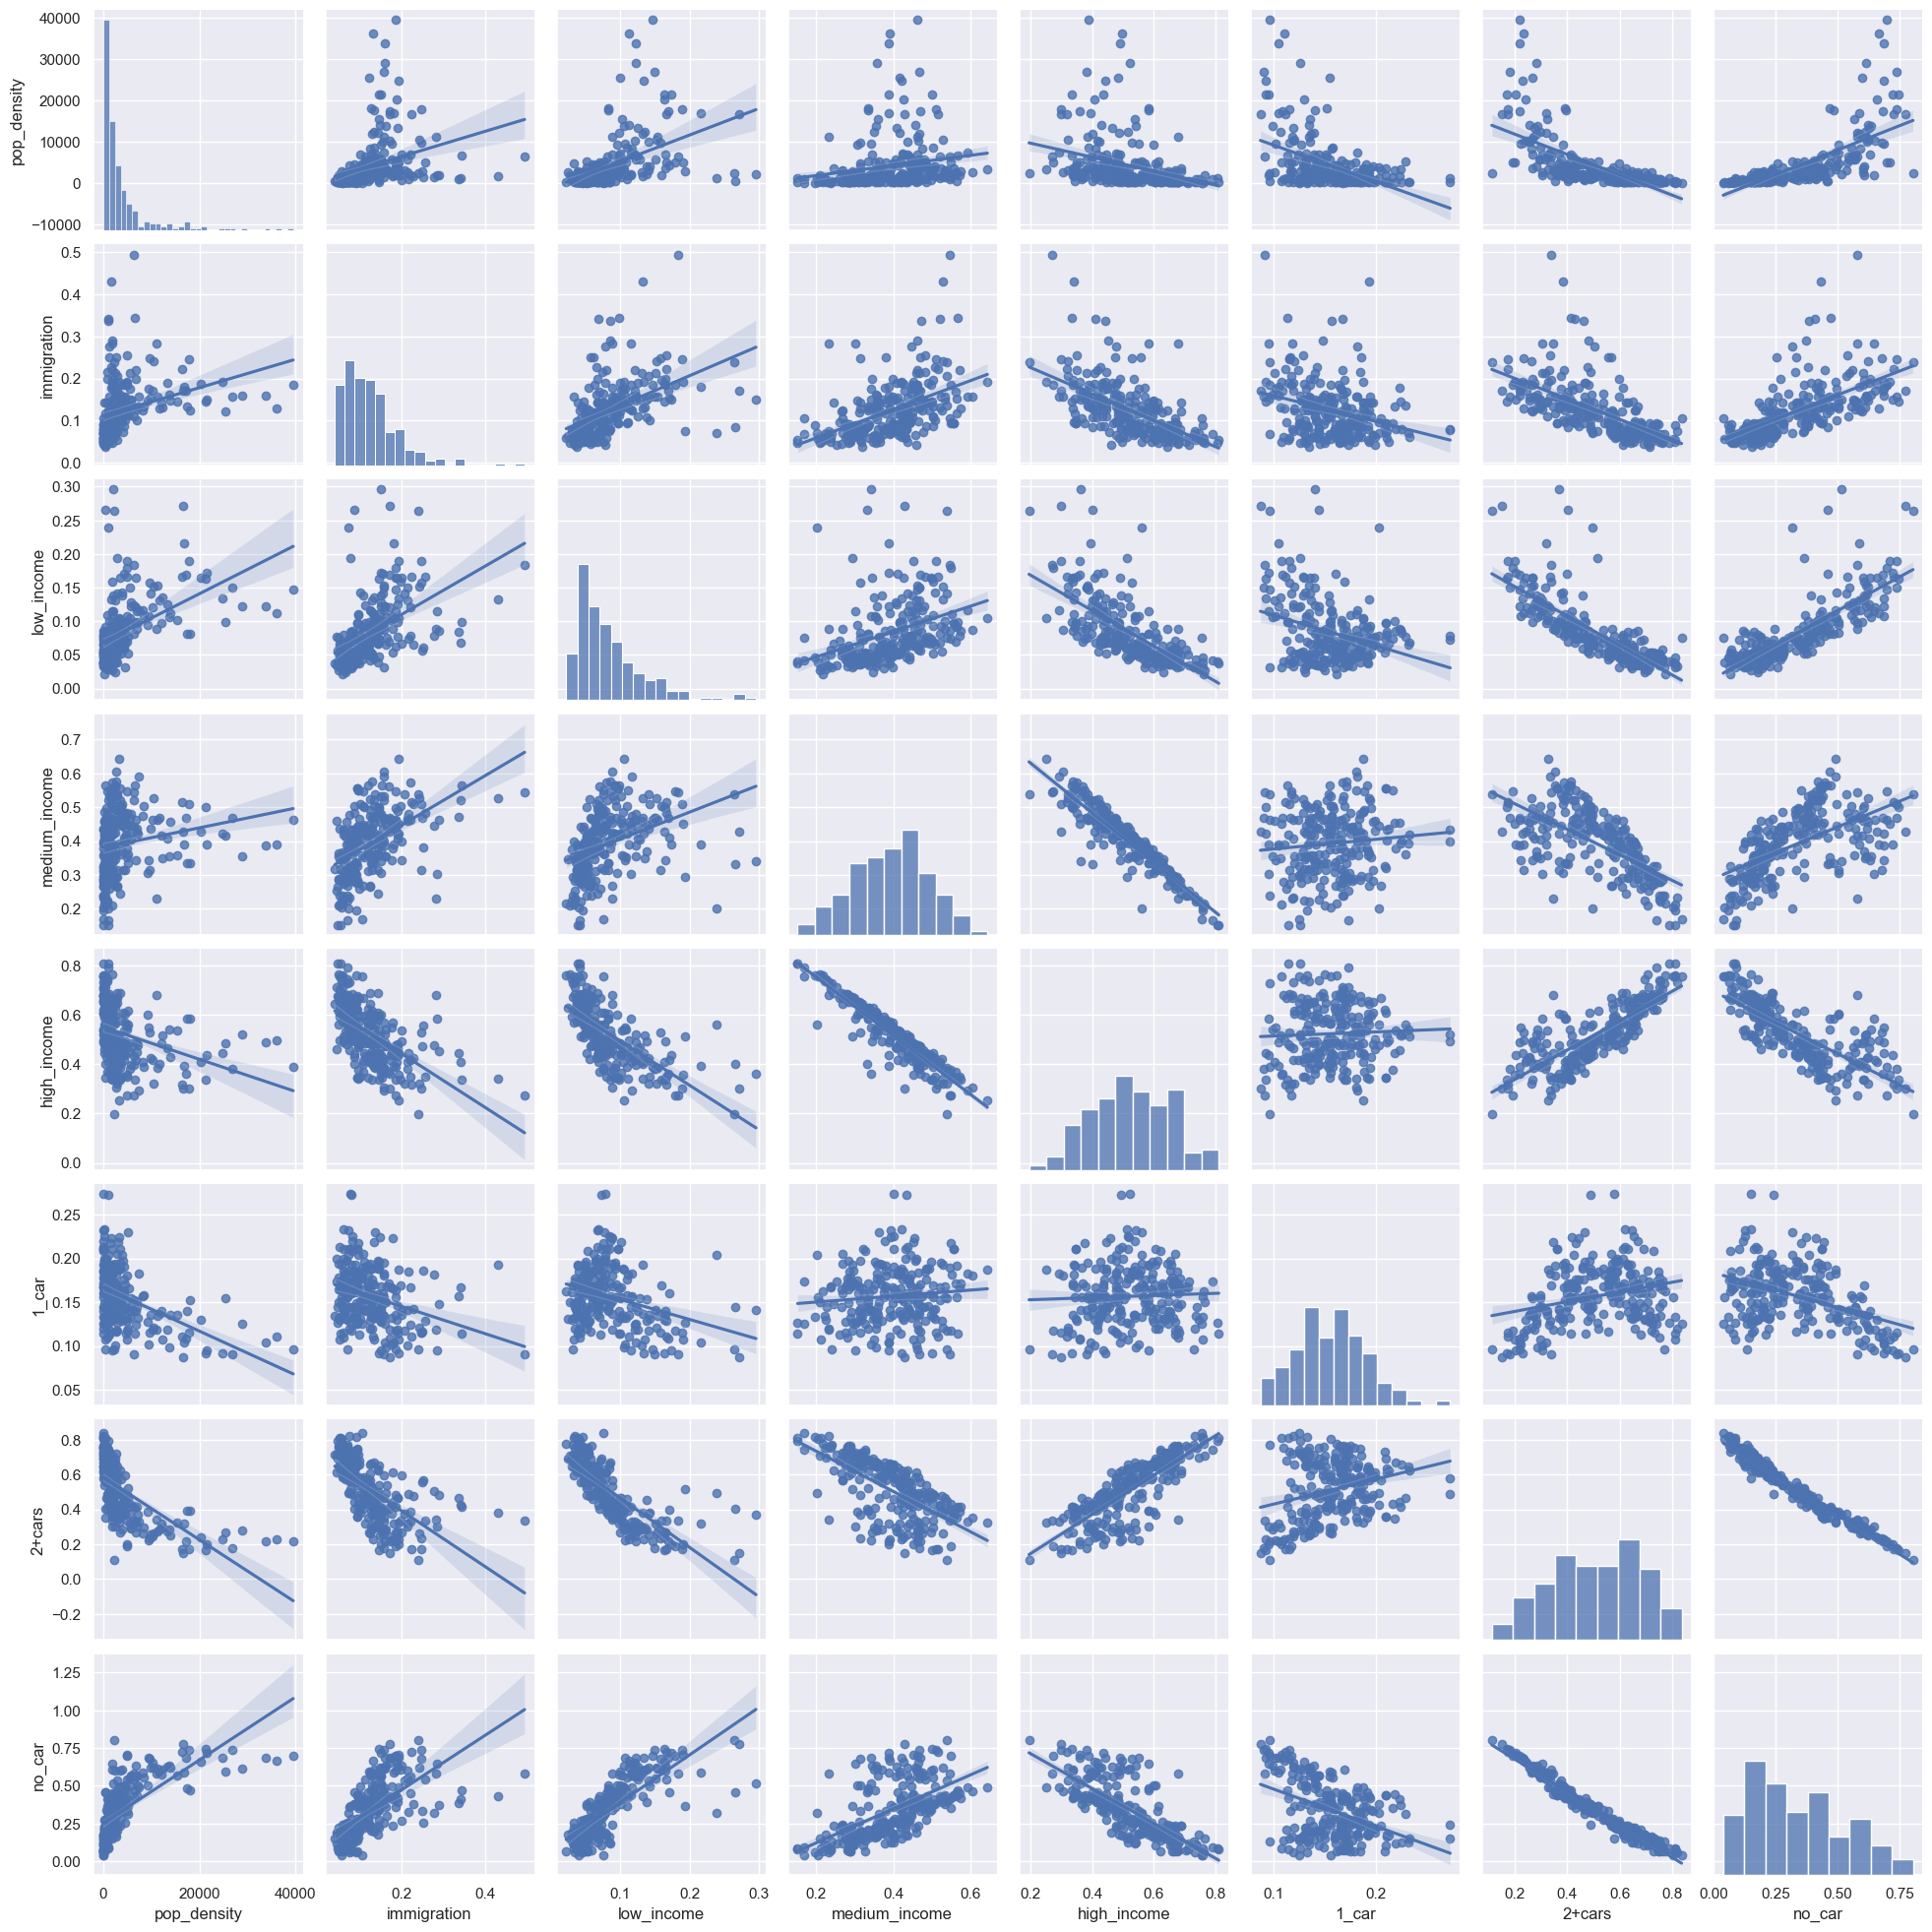

In [9]:
sns.pairplot(data[cluster_cols], kind='reg', diag_kind='hist');

This is helpful to consider uni and bivariate questions such as: *what is the relationship between high income and car ownership?* (Positive) *Are their areas with both a high share of high and low income households?* (Not really). However, sometimes, this is not enough and we are interested in more sophisticated questions that are truly multivariate and, in these cases, the figure above cannot help us. For example, it is not straightforward to answer questions like: *Are all areas with low car ownership similar?* *Are the Northen and Western suburbs similar?* For these kinds of multi-dimensional questions -involving multiple variables at the same time- we require a truly multidimensional method like statistical clustering.

## An geodemographic classification of Greater Copenhagen using K-means

<details>
<summary><b>Geodemographic analysis</b></summary>

A geodemographic analysis involves the classification of the areas that make up a geographical map into groups or categories of observations that are similar within each other but different between them. The classification is carried out using a statistical clustering algorithm that takes as input a set of attributes and returns the group ("labels" in the terminology) each observation belongs to. Depending on the particular algorithm employed, additional parameters, such as the desired number of clusters employed or more advanced tuning parameters (e.g. bandwith, radius, etc.), also need to be entered as inputs. For our geodemographic classification of demographic and socio-economic variables in Greater Cph, we will use one of the most popular clustering algorithms: K-means. This technique only requires as input the observation attributes and the final number of groups that we want it to cluster the observations into. In our case, we will usesix to begin with as this will allow us to have a closer look into each of them.

</details>

Although the underlying algorithm is not trivial, running K-means in Python is streamlined thanks to `scikit-learn`. Similar to the extensive set of available algorithms in the library, its computation is a matter of two lines of code. First, we need to specify the parameters in the `KMeans` method (which is part of `scikit-learn`'s `cluster` submodule). Note that, at this point, we do not even need to pass the data:

In [10]:
kmeans6 = cluster.KMeans(n_clusters=6, random_state=12345)

This sets up an object that holds all the parameters required to run the algorithm. In our case, we only passed the number of clusters(`n_clusters`) and the random state, a number that ensures every run of K-Means, which relies on random initialisations, is the same and thus reproducible.

To actually run the algorithm on the attributes, we need to call the `fit` method in `kmeans5`.
First, we make sure to standardize our data using the `robust_scaling` method from sklearn.

In [11]:
for c in cluster_cols:
    data[c+'_scaled'] = robust_scale(data[c])

In [12]:
cluster_cols_scaled = [c+'_scaled' for c in cluster_cols]

In [13]:
# Run the clustering algorithm
k6cls = kmeans6.fit(data[cluster_cols_scaled])

/opt/miniconda3/envs/gds_py/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The `k6cls` object we have just created contains several components that can be useful for an analysis. For now, we will use the labels, which represent the different categories in which we have grouped the data. Remember, in Python, life starts at zero, so the group labels go from zero to five. Labels can be  extracted as follows:

In [14]:
k6cls.labels_

array([5, 5, 3, 3, 2, 0, 1, 3, 1, 5, 5, 1, 1, 1, 3, 1, 3, 5, 3, 3, 5, 3,
       1, 2, 0, 4, 0, 1, 4, 2, 1, 3, 1, 5, 3, 1, 5, 1, 5, 0, 2, 0, 1, 3,
       3, 3, 5, 3, 5, 1, 1, 5, 1, 3, 3, 5, 5, 5, 5, 3, 5, 5, 5, 1, 1, 1,
       0, 1, 0, 5, 1, 0, 0, 3, 1, 3, 1, 3, 3, 4, 2, 2, 2, 2, 0, 0, 2, 3,
       0, 3, 5, 3, 5, 3, 5, 1, 1, 5, 1, 5, 5, 1, 1, 0, 5, 1, 3, 3, 5, 5,
       3, 0, 1, 1, 5, 5, 3, 1, 3, 5, 5, 5, 3, 1, 5, 5, 5, 3, 3, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 3, 5, 3, 5, 3, 3, 5, 3, 3, 3, 1, 5, 2, 2, 3,
       0, 4, 0, 2, 1, 2, 5, 1, 5, 1, 2, 5, 1, 2, 1, 1, 0, 0, 0, 5, 1, 5,
       1, 0, 5, 5, 5, 0, 1, 2, 2, 5, 0, 5, 2, 1, 1, 5, 2, 3, 2, 2, 1, 2,
       3, 5, 3, 1, 5, 5, 3, 1, 4, 5, 2, 3, 2, 5, 0, 3, 5, 0, 0, 4, 1, 1,
       3, 0, 5, 0, 3, 5, 5, 0, 3, 5, 4, 1, 5, 3, 0, 1, 3, 1, 3, 3, 5, 5,
       1, 1, 0, 2], dtype=int32)

Each number represents a different category, so two observations with the same number belong to same group. The labels are returned in the same order as the input attributes were passed in, which means we can append them to the original table of data as an additional column:

In [15]:
data['k6cls'] = k6cls.labels_
data.head(3)

Gruppe municipal_id      area_name  \
Gruppe                                       
210008  210008         0210        Karlebo   
183001  183001         0183  Ishøj Landsby   
260001  260001         0260      Hundested   

                                                 geometry  total_population  \
Gruppe                                                                        
210008  MULTIPOLYGON Z (((710547.580 6203125.960 0.000...            1189.0   
183001  MULTIPOLYGON Z (((709453.040 6170688.130 0.000...            1947.0   
260001  MULTIPOLYGON Z (((682683.090 6210144.300 0.000...            9692.0   

        pop_density  low_income  medium_income  high_income  immigration  ...  \
Gruppe                                                                    ...   
210008    46.179265    0.045894       0.195652     0.758454     0.089992  ...   
183001   126.623621    0.054201       0.276423     0.669377     0.093991  ...   
260001   303.805664    0.064054       0.456887     0.479059     0.065827  ...   

          no_car  pop_density_scaled  immigration_scaled  low_income_scaled  \
Gruppe                                                                        
210008  0.057971           -0.479953           -0.274697          -0.452104   
183001  0.159892           -0.458877           -0.223778          -0.294164   
260001  0.220829           -0.412457           -0.582363          -0.106821   

        medium_income_scaled  high_income_scaled  1_car_scaled  2+cars_scaled  \
Gruppe                                                                          
210008             -1.392004            1.267600     -0.492848       1.097069   
183001             -0.838238            0.797972     -0.607876       0.728009   
260001              0.399030           -0.205404      0.865205       0.247031   

        no_car_scaled  k6cls  
Gruppe                        
210008      -0.909965      5  
183001      -0.552075      5  
260001      -0.338097      3  

[3 rows x 23 columns]

### Mapping the categories

To get a better understanding of the classification we have just performed, it is useful to display the categories created on a map. For this, we will use a unique values choropleth, which will automatically assign a different color to each category:

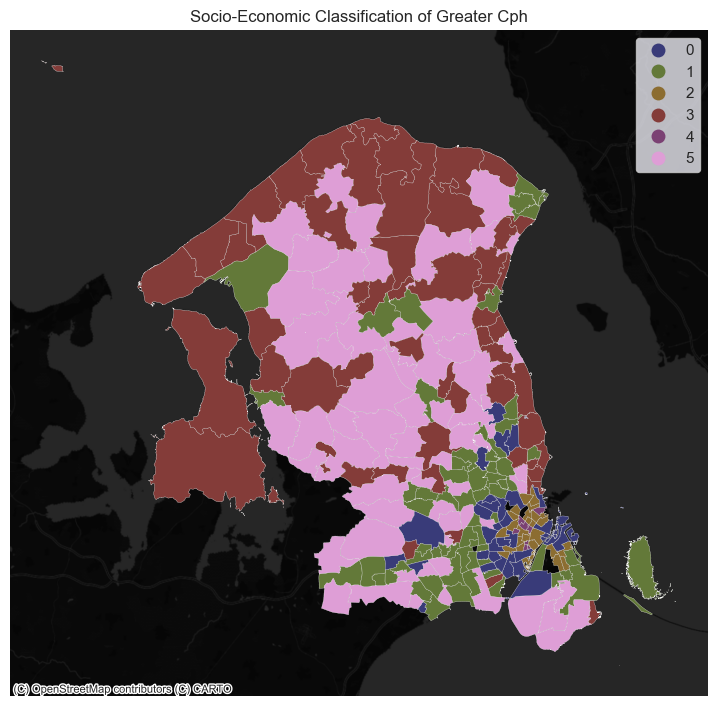

In [16]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
data.plot(
    column='k6cls', 
    categorical=True, 
    legend=True, 
    linewidth=0.2, 
    ax=ax, 
    cmap='tab20b'
)
# Remove axis
ax.set_axis_off()
# Add title
plt.title('Socio-Economic Classification of Greater Cph')

# Add basemap
cx.add_basemap(
    ax,
    crs=muni.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels
)

# Display the map
plt.show()

The map above represents the geographical distribution of the six categories created by the K-means algorithm. A quick glance shows a strong spatial structure in the distribution of the colors: even though the algorithm did not include the location of values, several spatially connected clusters appear.

### Exploring the nature of the categories

Once we have a sense of where and how the categories are distributed over space, it is also useful to explore them statistically. This will allow us to characterize them, giving us an idea of the kind of observations subsumed into each of them. As a first step, let us find how many observations are in each category. To do that, we will make use of the `groupby` operator, combined with the function `size`, which returns the number of elements in a subgroup:

In [17]:
k6sizes = data.groupby('k6cls').size()
k6sizes

k6cls
0    31
1    64
2    25
3    54
4     7
5    65
dtype: int64

The `groupby` operator groups a table (`DataFrame`) using the values in the column provided (`k6cls`) and passes them onto the function provided afterwards, which in this case is `size`. Effectively, what this does is to groupby the observations by the categories created and count how many of them each contains. For a more visual representation of the output, a bar plot is a good alternative:

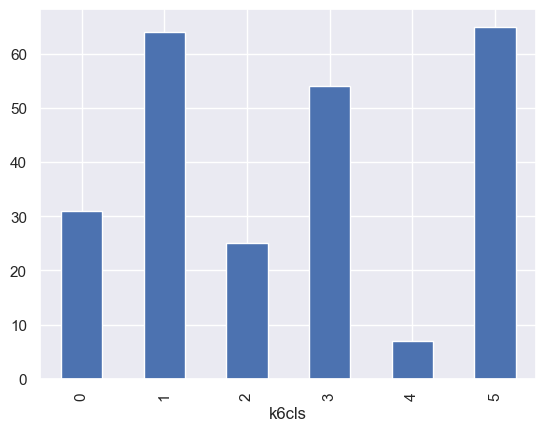

In [18]:
k6sizes.plot.bar();

As we suspected from the map, the clusters have very different sizes.

In order to describe the nature of each category, we can look at the values of each of the attributes we have used to create them in the first place, for example by checking the average value of each. To do that in Python, we will rely on the `groupby` operator which we will combine it with the function `mean`:

In [19]:
# Calculate the mean by group
k6means = data.groupby('k6cls')[cluster_cols].mean()
# Show the table transposed (so it's not too wide)
k6means.T

k6cls                    0            1             2            3  \
pop_density    4549.862283  2825.654579  14297.744110  1023.629946   
immigration       0.191106     0.151409      0.174050     0.086479   
low_income        0.155605     0.082189      0.140104     0.059726   
medium_income     0.442469     0.481305      0.407718     0.383410   
high_income       0.401925     0.436506      0.452178     0.556864   
1_car             0.134960     0.169552      0.119357     0.190200   
2+cars            0.332221     0.448677      0.266735     0.598819   
no_car            0.547885     0.387212      0.629999     0.215014   

k6cls                     4           5  
pop_density    30750.755864  932.258529  
immigration        0.157201    0.075162  
low_income         0.126611    0.043606  
medium_income      0.414598    0.281656  
high_income        0.458791    0.674738  
1_car              0.110586    0.146253  
2+cars             0.231874    0.710217  
no_car             0.668591    0.145939

A better way of constructing cluster profiles is to draw the distributions of cluster members’ data. To do this we need to “tidy up” the dataset. A tidy dataset is one where every row is an observation, and every column is a variable:

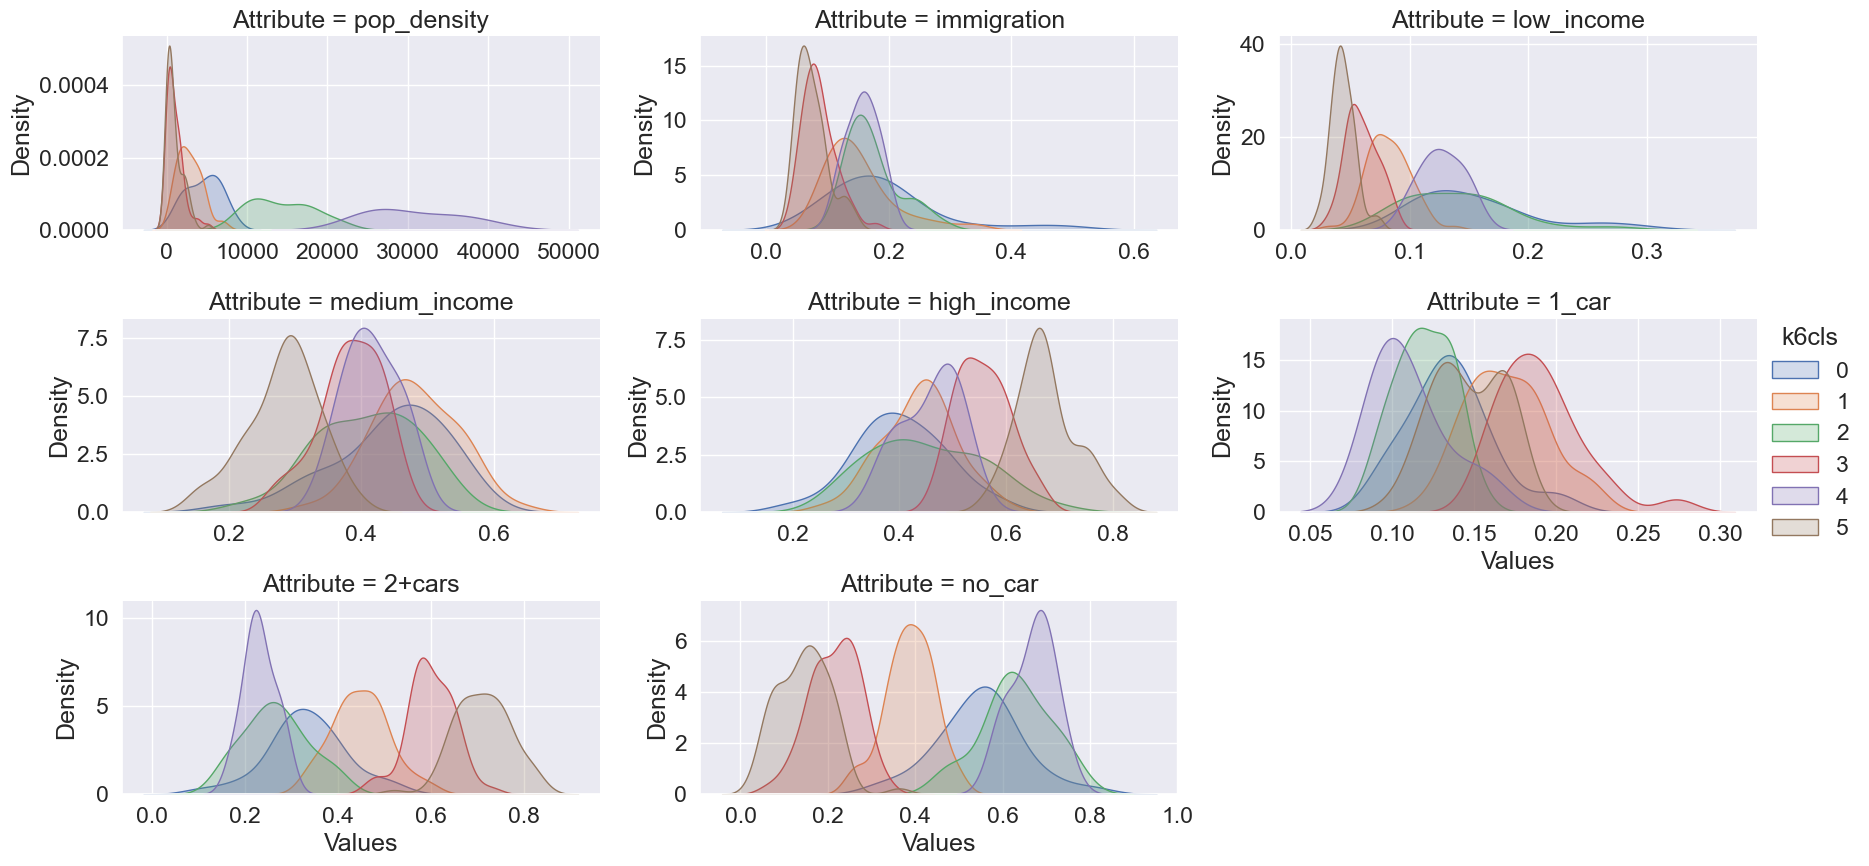

In [20]:
# Index db on cluster ID
tidy_db = data.set_index('k6cls')
# Keep only variables used for clustering
tidy_db = tidy_db[cluster_cols]
# Stack column names into a column, obtaining
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(
    columns={"level_1": "Attribute", 0: "Values"}
)
# Check out result
tidy_db.head(30)


# Scale fonts to make them more readable
sns.set(font_scale=1.5)
# Setup the facets
facets = sns.FacetGrid(
    data=tidy_db,
    col="Attribute",
    hue='k6cls',
    sharey=False,
    sharex=False,
    aspect=2,
    col_wrap=3,
)
# Build the plot from `sns.kdeplot`
facets.map(sns.kdeplot, "Values", fill=True,warn_singular=False).add_legend();

This concludes the section on geodemographics. As we have seen, the essence of this approach is to group areas based on a purely statistical basis: *where* each area is located is irrelevant for the label it receives from the clustering algorithm. In many contexts, this is not only permissible but even desirable, as the interest is to see if particular combinations of values are distributed over space in any discernible way. However, in other context, we may be interested in created groups of observations that follow certain spatial constraints. For that, we now turn into regionalization techniques.

## Regionalization algorithms


<details>

<summary>Regionalization background</summary>

Regionalization is the subset of clustering techniques that impose a spatial constraint on the classification. In other words, the result of a regionalization algorithm contains areas that are spatially contiguous. Effectively, what this means is that these techniques aggregate areas into a smaller set of larger ones, called regions. In this context then, areas are *nested* within regions. Real world examples of this phenomenon includes counties within states or, in the UK, local super output areas (LSOAs) into middle super output areas (MSOAs). The difference between those examples and the output of a regionalization algorithm is that while the former are aggregated based on administrative principles, the latter follows a statistical technique that, very much the same as in the standard statistical clustering, groups together areas that are similar on the basis of a set of attributes. Only that now, such statistical clustering is spatially constrained.

As in the non-spatial case, there are many different algorithms to perform regionalization, and they all differ on details relating to the way they measure (dis)similarity, the process to regionalize, etc. However, same as above too, they all share a few common aspects. In particular, they all take a set of input attributes *and* a representation of space in the form of a binary spatial weights matrix. Depending on the algorithm, they also require the desired number of output regions into which the areas are aggregated.

To illustrate these concepts, we will run a regionalization algorithm on the socio-economic data we have been using. In this case, the goal will be to re-delineate the boundary lines following a rationale based on the different average values, instead of the administrative reasons behind the existing boundary lines. In this way, the resulting regions will represent a consistent set of areas that are similar with each other in terms of income etc.

</details>


### Defining space formally

Very much in the same way as with ESDA techniques, regionalization methods require a formal representation of space that is statistics-friendly. In practice, this means that we will need to create a spatial weights matrix for the areas to be aggregated.

Because of the (geographical) islands in our data set we use a K-nearest-neighbor methods, which technically does not guarantee that neighbors are spatially connected.
Keeping the value of K low will however make sure that most neighbors are actually adjacent.


In [21]:
w = weights.KNN.from_dataframe(data,k=4,ids='Gruppe')

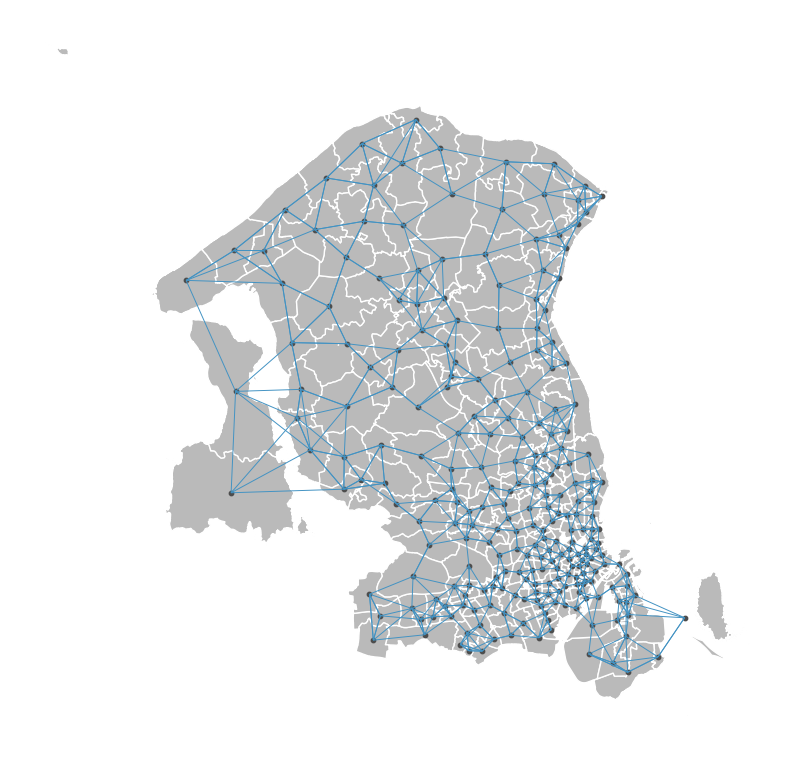

In [22]:
plot_spatial_weights(w, data,indexed_on='Gruppe');

### Creating regions from areas

At this point, we have all the pieces needed to run a regionalization algorithm. For this example, we will use a spatially-constrained version of the agglomerative algorithm. This is a similar approach to that used above (the inner-workings of the algorithm are different however) with the difference that, in this case, observations can only be labelled in the same group if they are spatial neighbors, as defined by our spatial weights matrix `w`. The way to interact with the algorithm is very similar to that above. We first set the parameters:

*Note that you usually will want to create more clusters than when running e.g. K-Means with no spatial constraint, since similar but disconnected areas will create each their cluster*

In [23]:
sagg13 = cluster.AgglomerativeClustering(n_clusters=12, connectivity=w.sparse)
sagg13

AgglomerativeClustering(connectivity=<246x246 sparse matrix of type '<class 'numpy.float64'>'
	with 984 stored elements in Compressed Sparse Row format>,
                        n_clusters=12)

And we can run the algorithm by calling `fit`:

In [24]:
# Run the clustering algorithm - again using the scaled data
sagg13cls = sagg13.fit(data[cluster_cols_scaled])

And then we append the labels to the table:

In [25]:
data['sagg13cls'] = sagg13cls.labels_

In [26]:
# Calculate the mean by group
sagg13_data = data.groupby('sagg13cls')[cluster_cols].mean()
# Show the table transposed (so it's not too wide)
sagg13_data.T

sagg13cls                0            1            2           3           4   \
pop_density    19497.760851  7146.199001  3040.202521  759.294253  273.545242   
immigration        0.165645     0.165979     0.156305    0.081716    0.074062   
low_income         0.140096     0.131431     0.092747    0.048267    0.071560   
medium_income      0.417539     0.426598     0.455177    0.325476    0.419741   
high_income        0.442366     0.441972     0.452076    0.626257    0.508699   
1_car              0.117226     0.130831     0.157694    0.165011    0.210255   
2+cars             0.248615     0.312041     0.466906    0.660765    0.612577   
no_car             0.649290     0.569933     0.383022    0.177076    0.180669   

sagg13cls                5             6            7            8   \
pop_density    34911.816354  39496.315012  1393.211415  2912.946500   
immigration        0.144366      0.184242     0.062682     0.122613   
low_income         0.116918      0.146898     0.037712     0.070231   
medium_income      0.388938      0.462918     0.259672     0.301107   
high_income        0.494144      0.390184     0.702617     0.628662   
1_car              0.107497      0.095968     0.113780     0.192125   
2+cars             0.224176      0.217443     0.755398     0.545289   
no_car             0.676465      0.697028     0.133157     0.271179   

sagg13cls               9            10           11  
pop_density    1066.464037  2521.574788  6370.707334  
immigration       0.074559     0.115825     0.494174  
low_income        0.049148     0.084371     0.183398  
medium_income     0.296335     0.536395     0.544788  
high_income       0.654517     0.379235     0.271815  
1_car             0.126774     0.183647     0.091120  
2+cars            0.693975     0.416645     0.338610  
no_car            0.180671     0.403038     0.577992

In [27]:
# Index db on cluster ID
tidy_db = data.set_index('sagg13cls')
# Keep only variables used for clustering
tidy_db = tidy_db[cluster_cols]
# Stack column names into a column, obtaining
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(
    columns={"level_1": "Attribute", 0: "Values"}
)
# Check out result
tidy_db.head(30)


sagg13cls      Attribute       Values
0           3    pop_density    46.179265
1           3    immigration     0.089992
2           3     low_income     0.045894
3           3  medium_income     0.195652
4           3    high_income     0.758454
5           3          1_car     0.132850
6           3         2+cars     0.814010
7           3         no_car     0.057971
8           3    pop_density   126.623621
9           3    immigration     0.093991
10          3     low_income     0.054201
11          3  medium_income     0.276423
12          3    high_income     0.669377
13          3          1_car     0.127371
14          3         2+cars     0.714092
15          3         no_car     0.159892
16          4    pop_density   303.805664
17          4    immigration     0.065827
18          4     low_income     0.064054
19          4  medium_income     0.456887
20          4    high_income     0.479059
21          4          1_car     0.197536
22          4         2+cars     0.583875
23          4         no_car     0.220829
24          2    pop_density  3641.966095
25          2    immigration     0.117096
26          2     low_income     0.059603
27          2  medium_income     0.362252
28          2    high_income     0.578146
29          2          1_car     0.150331

In [28]:
# custom colormap to ensure uniform colors between plots and maps
colors = ["#a6cee3",
"#1f78b4",
"#b2df8a",
"#33a02c",
"#fb9a99",
"#e31a1c",
"#fdbf6f",
"#ff7f00",
"#cab2d6",
"#6a3d9a",
"#ffff99",
"#b15928"]

keys = list(range(0,12))

color_dict={}

for k, c in zip(keys, colors):
    color_dict[k] = c

vals = data.sagg13cls.unique()
vals.sort()
cmap = mpl.colors.ListedColormap([color_dict[b] for b in vals])

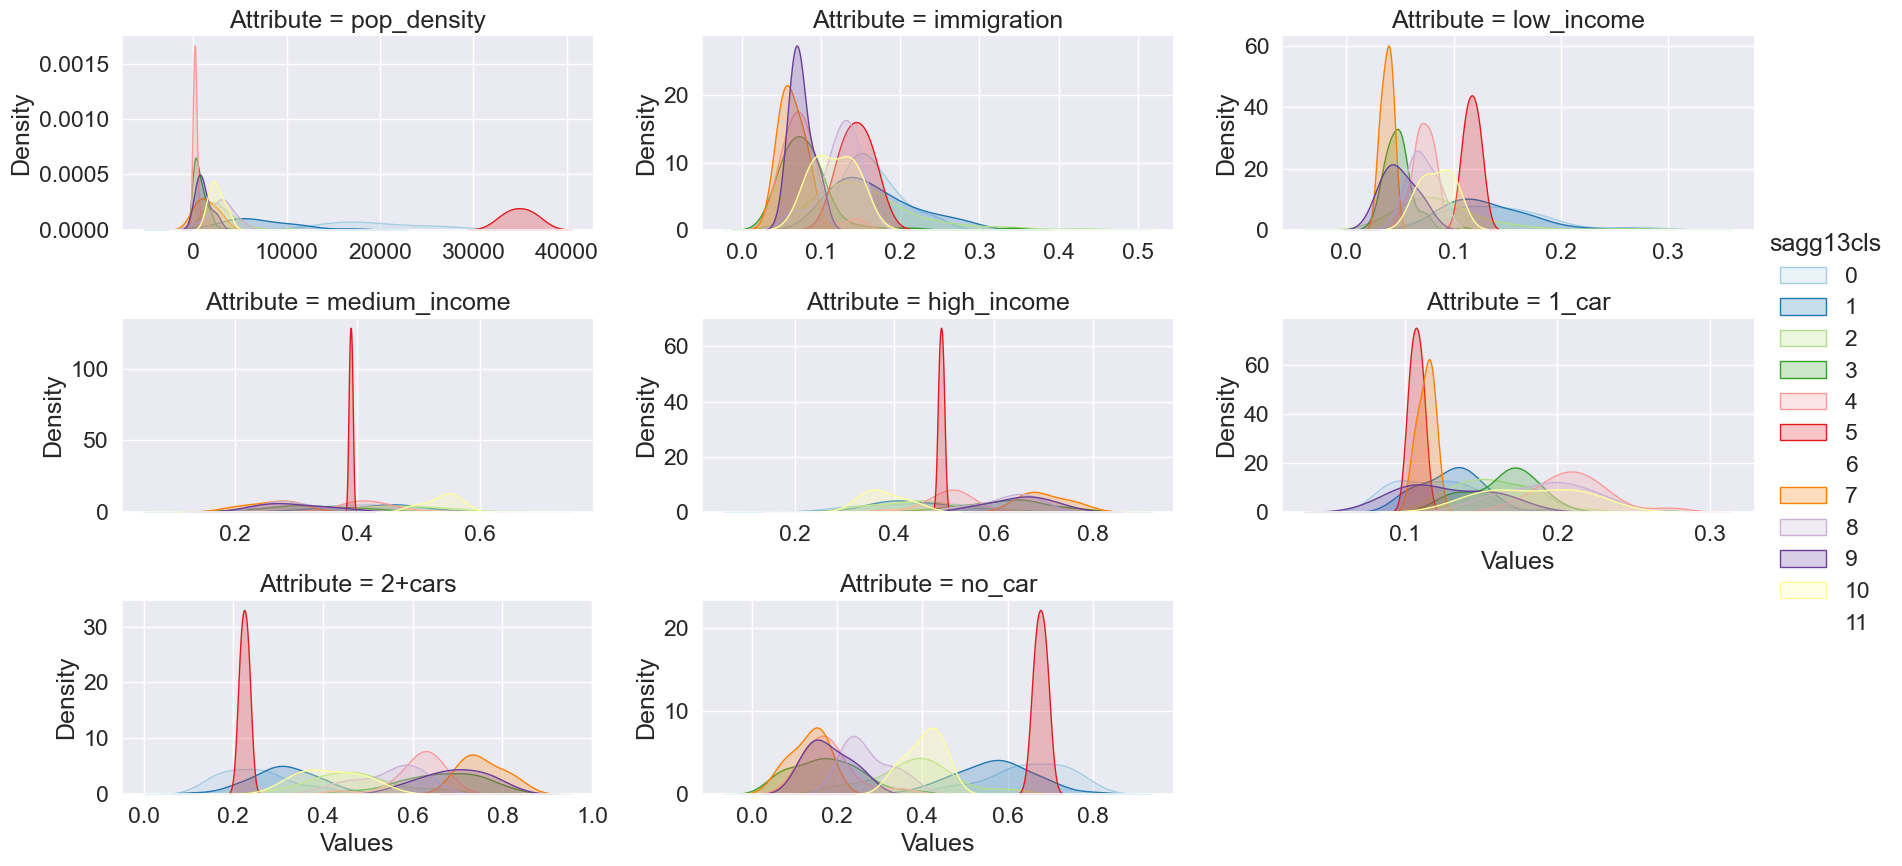

In [29]:
# Scale fonts to make them more readable
sns.set(font_scale=1.5)
# Setup the facets
facets = sns.FacetGrid(
    data=tidy_db,
    col="Attribute",
    hue='sagg13cls',
    sharey=False,
    sharex=False,
    aspect=2,
    palette= colors, #'tab20',
    col_wrap=3,
)
# Build the plot from `sns.kdeplot`
facets.map(sns.kdeplot, "Values", fill=True, warn_singular=False).add_legend();

**OBS:** Notice that clusters/regions with only one member are not plotted in the density plot

### Mapping the resulting regions

At this point, the column `sagg13cls` is no different than `k6cls`: a categorical variable that can be mapped into a unique values choropleth. In fact the following code snippett is exactly the same as before, only replacing the name of the variable to be mapped and the title:

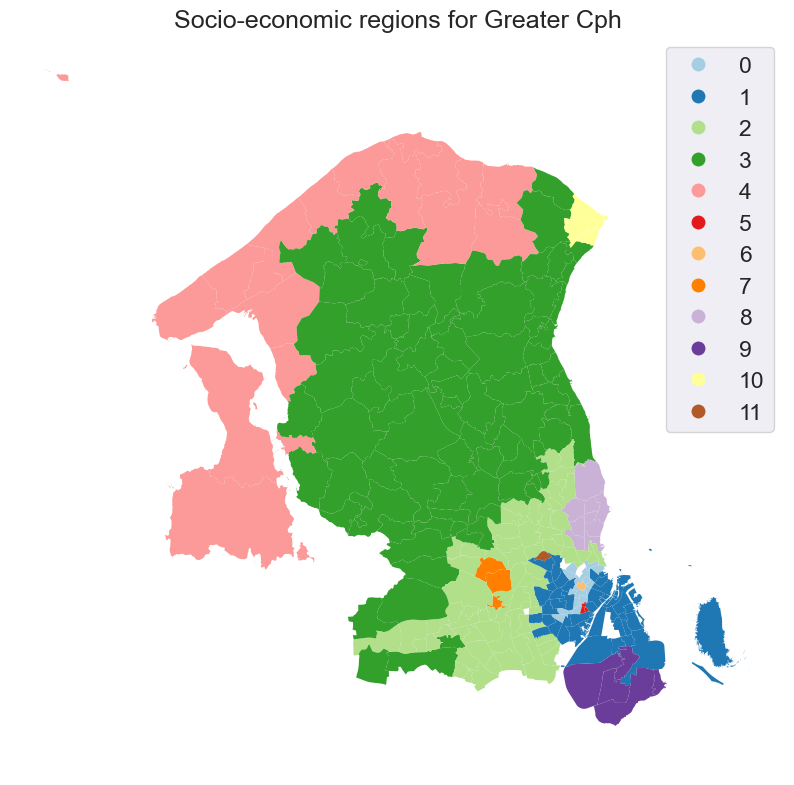

In [30]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(10,10))
# Plot unique values choropleth including a legend and with no boundary lines
data.plot(
    column='sagg13cls', categorical=True, legend=True, linewidth=0, cmap=cmap, ax=ax
)
# Remove axis
ax.set_axis_off()
# Add title
plt.title('Socio-economic regions for Greater Cph')
# Display the map
plt.show()

### Comparing organic and administrative delineations

The map above gives a very clear impression of the boundary delineation of the algorithm. However, it is still based on the small area polygons. To create the new boroughs "properly", we need to dissolve all the polygons in each category into a single one. This is a standard GIS operation that is supported by `geopandas`. The only additional complication is that we need to wrap it into a separate function to be able to pass it on to `groupby`. We first the define the function `dissolve`:

In [31]:
def dissolve(gs):
    '''
    Take a series of polygons and dissolve them into a single one
    
    Arguments
    ---------
    gs        : GeoSeries
                Sequence of polygons to be dissolved
    Returns
    -------
    dissolved : Polygon
                Single polygon containing all the polygons in `gs`
    '''
    return gs.unary_union

The boundaries for the clustering regions can then be obtained as follows:

In [32]:
# Dissolve the polygons based on `sagg13cls`
data_regions = gpd.GeoDataFrame(geometry=
    data.groupby(data['sagg13cls']).apply(dissolve),
    crs=data.crs
)
data_regions['cluster'] = data_regions.index

/opt/miniconda3/envs/gds_py/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1784: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


Which we can plot:

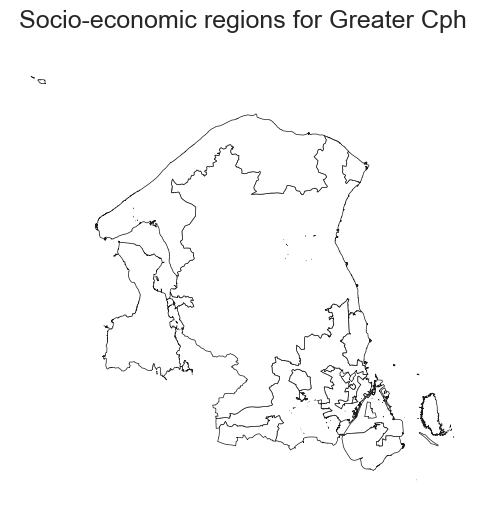

In [33]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot boundary lines
data_regions.plot(
    ax=ax, 
    linewidth=0.5,
    facecolor='white', 
    edgecolor='k'
)
# Remove axis
ax.set_axis_off()
# Add title
plt.title('Socio-economic regions for Greater Cph');

The delineation above provides a view into the geography of socio-economic regions in and around Copenhagen (based on the considered variables!). Each region delineated contains areas that, according to our regionalisation algorithm, are more similar with each other than those in the neighboring areas. Now let's compare this geography that we have organically drawn from our data with that of the official set of administrative boundaries. For example, with the municipalities.

Remember we created these at the beginning of the notebook:

In [34]:
muni.head(3)

geometry
municipal_id                                                   
0101          MULTIPOLYGON Z (((723134.230 6171891.850 0.000...
0147          POLYGON Z ((723623.500 6176329.840 0.000, 7236...
0155          MULTIPOLYGON Z (((734178.900 6160734.650 0.000...

And displayed in a similar way as with the newly created ones:

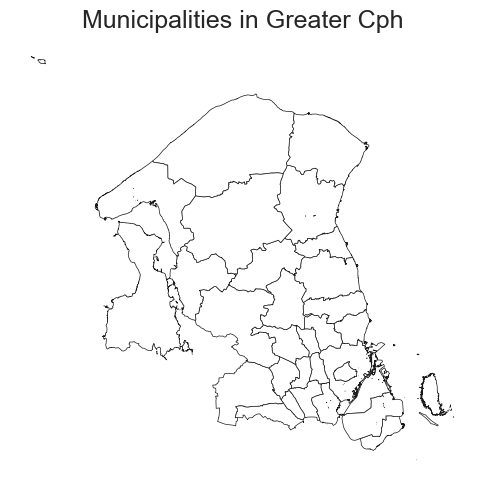

In [35]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot boundary lines
muni.plot(
    ax=ax, 
    linewidth=0.5,
    edgecolor='k', 
    facecolor='white'
)
# Remove axis
ax.set_axis_off()
# Add title
plt.title('Municipalities in Greater Cph');

In order to more easily compare the administrative and the "regionalized" boundary lines, we can overlay them:

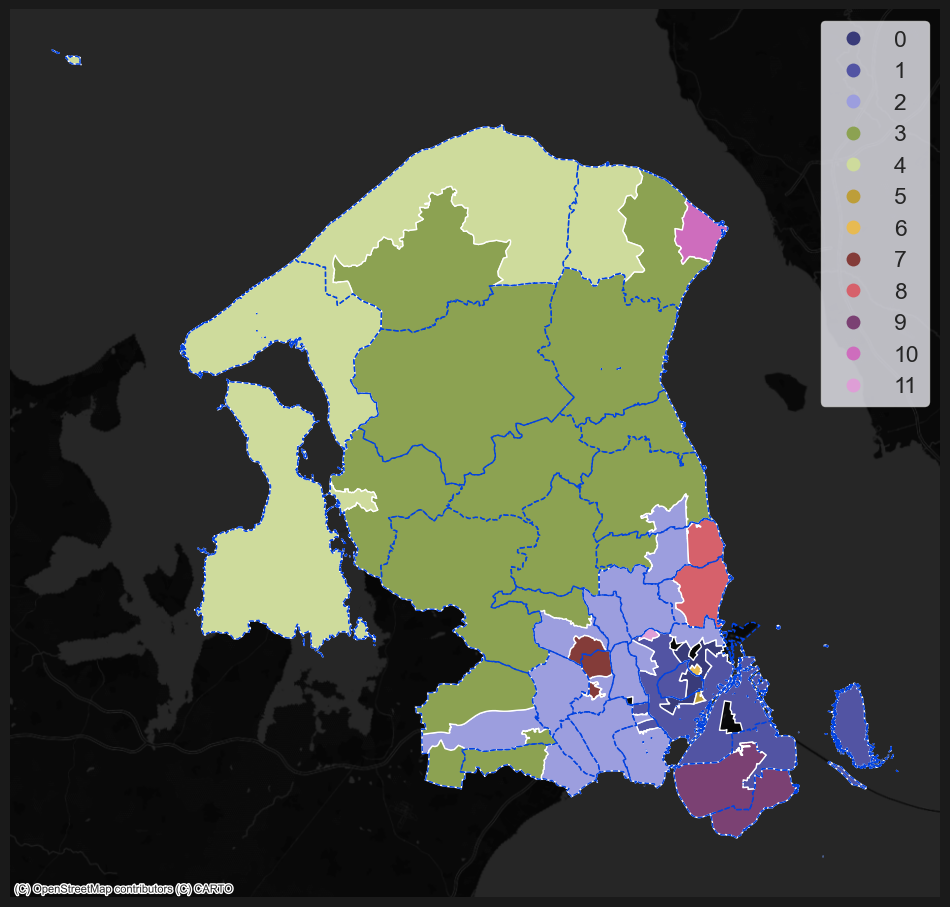

In [36]:
# Set up figure
f, ax = plt.subplots(1, figsize=(12, 12))
f.set_facecolor("k")

# Add regionalisation geography
data_regions.plot(
    ax=ax,
    column='cluster',
    categorical=True,
    cmap='tab20b',
    legend=True
)

# Add municipalities
muni.plot(
    ax=ax,
    facecolor="none",
    edgecolor="xkcd:blue",
    linewidth=1,
    linestyle='dashed'
)

# Add basemap
cx.add_basemap(
    ax,
    crs=muni.crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels
)

# Remove axis
ax.set_axis_off()
# Display clean
plt.show()

Looking at the figure, we can see that several or the more rural municipalities have ended up completely covered by one cluster/region, while the more urban one on the other hand shows considerably more variation. It is also evident that some of the clusters span across municipal divides.

In [37]:
data_regions.explore()